<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('darkgrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')
house.columns

Index([u'Id', u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea',
       u'Street', u'Alley', u'LotShape', u'LandContour', u'Utilities',
       u'LotConfig', u'LandSlope', u'Neighborhood', u'Condition1',
       u'Condition2', u'BldgType', u'HouseStyle', u'OverallQual',
       u'OverallCond', u'YearBuilt', u'YearRemodAdd', u'RoofStyle',
       u'RoofMatl', u'Exterior1st', u'Exterior2nd', u'MasVnrType',
       u'MasVnrArea', u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual',
       u'BsmtCond', u'BsmtExposure', u'BsmtFinType1', u'BsmtFinSF1',
       u'BsmtFinType2', u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF',
       u'Heating', u'HeatingQC', u'CentralAir', u'Electrical', u'1stFlrSF',
       u'2ndFlrSF', u'LowQualFinSF', u'GrLivArea', u'BsmtFullBath',
       u'BsmtHalfBath', u'FullBath', u'HalfBath', u'BedroomAbvGr',
       u'KitchenAbvGr', u'KitchenQual', u'TotRmsAbvGrd', u'Functional',
       u'Fireplaces', u'FireplaceQu', u'GarageType', u'GarageYrBlt',
       u'GarageFinish',

In [3]:
house.shape

(1460, 81)

In [4]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [5]:
house.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [6]:
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


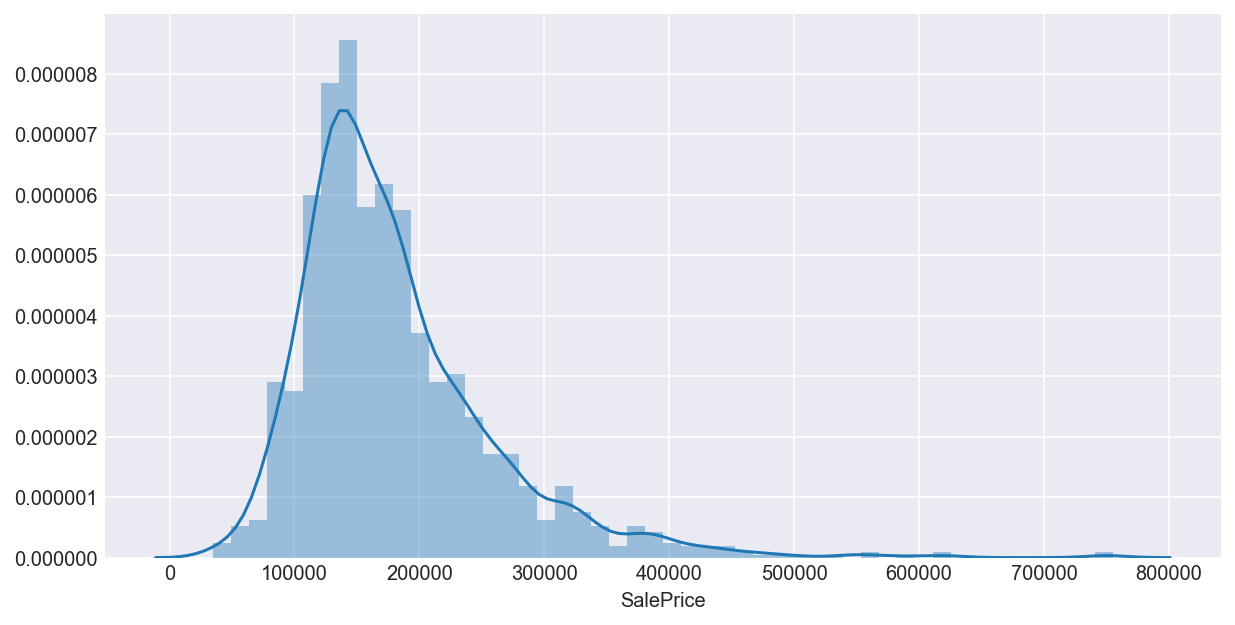

In [7]:
# Set the default matplotlib figure size:
fig = plt.subplots(figsize=(10,5))
sns.distplot(house["SalePrice"], bins=50,)

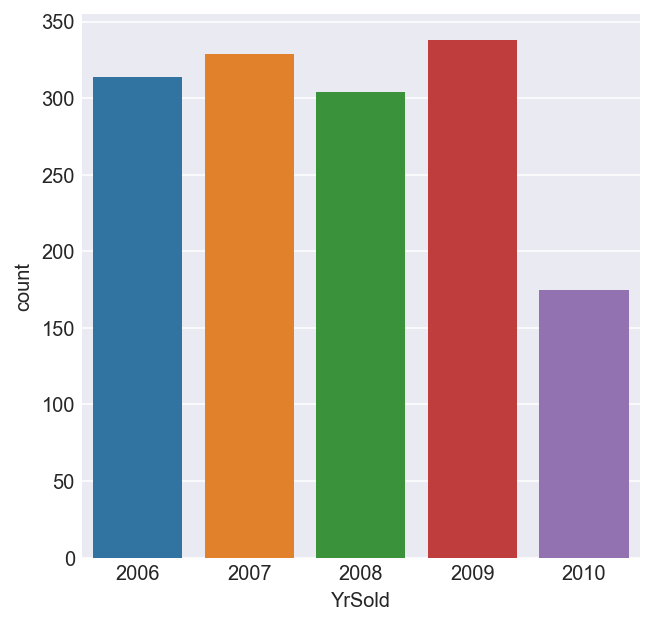

In [8]:
# House sold from Yr 2006 to Yr 2010.

fig = plt.subplots(figsize=(5,5))
sns.countplot(x="YrSold",data=house,)

In [9]:
house2 = house.copy()
house2.shape

(1460, 81)

In [10]:
# Question Part 1.1 , Dropping Id columns and  all renovatable items.  
# Reducing nos of Columns          

house.drop(["Id"],axis=1,inplace=True)

#17 items identify as renovatable items
renovatable = ["Utilities","RoofStyle","RoofMatl","Exterior1st","Exterior2nd",'ExterQual',"ExterCond",
               "BsmtFinType2","Heating","HeatingQC","CentralAir","Electrical","KitchenQual",
               "FireplaceQu","GarageFinish","GarageQual","GarageCond"]

house.drop(renovatable,axis=1,inplace=True)

In [11]:
# verifying check on items dropping renovatable items
house.shape

(1460, 63)

In [12]:
#Question Part 1.2  Reduce nos of Rows by 10 nos for Non residential house.
house=house[house["MSZoning"]!="C (all)"] # Masking for all other and delete "C" Commercial 

In [13]:
# verifying check on items dropping Non Residential house.
house.shape

(1450, 63)

In [14]:
# Question Part 1.2.1 Looking for NaN Columns
house.isnull().sum()

MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1361
LotShape            0
LandContour         0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
MasVnrType          8
MasVnrArea          8
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
                 ... 
GrLivArea           0
BsmtFullBath        0
BsmtHalfBath        0
FullBath            0
HalfBath            0
BedroomAbvGr        0
KitchenAbvGr        0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
GarageType         79
GarageYrBlt        79
GarageCars          0
GarageArea          0
PavedDrive

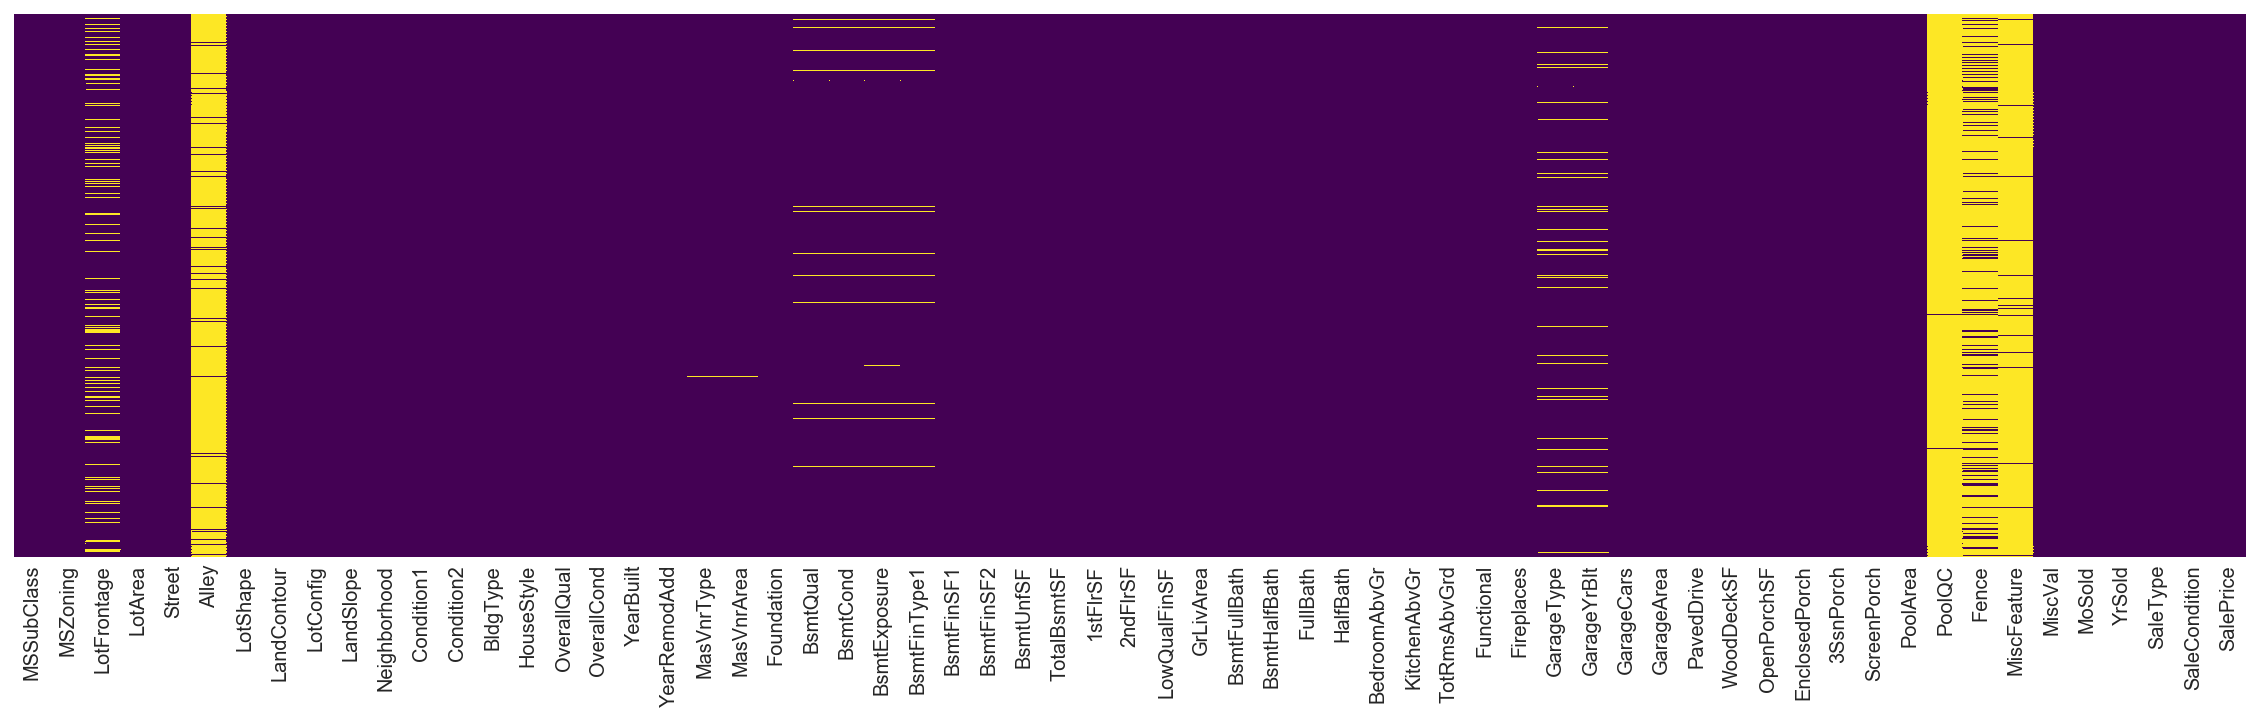

In [15]:
# using visual to check for columns with Null....Original Without Dropping any columns
fig = plt.subplots(figsize=(20,5))
sns.heatmap(house.isnull(), yticklabels=False,cbar=False,cmap="viridis")

In [16]:
# Reduce nos of Colums...Dropping features lesa than 20% information
house.drop(["PoolQC", "MiscVal", "Alley"],axis=1,inplace=True)

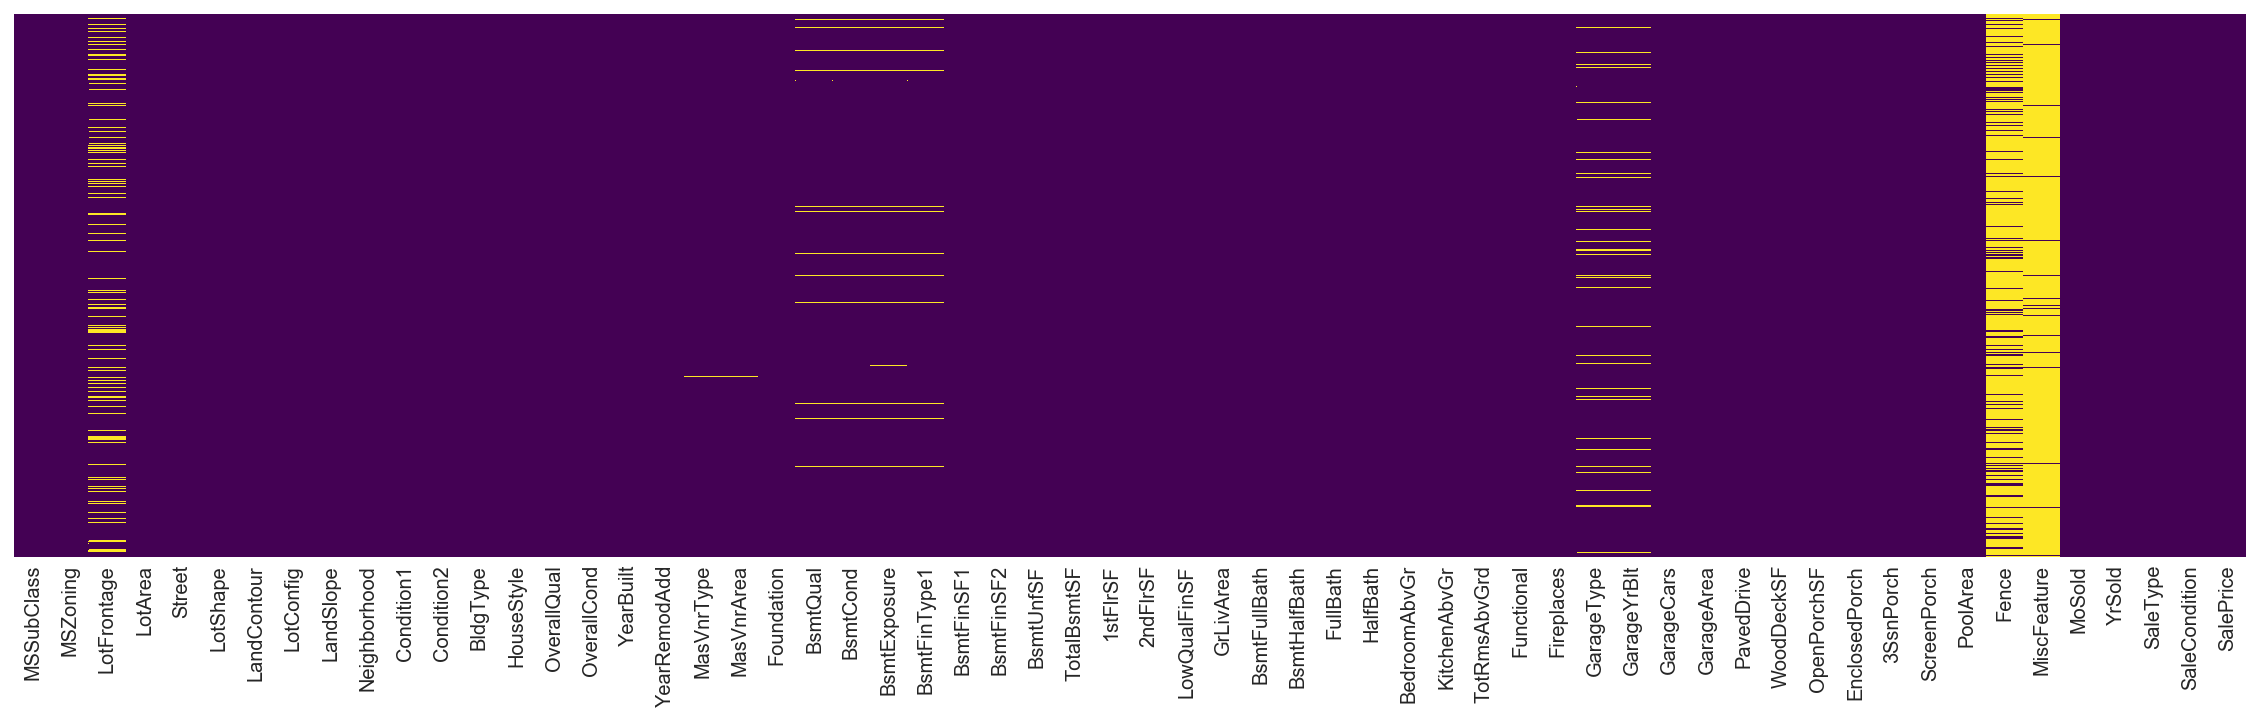

In [17]:
# using visual to check for columns with Null....
fig = plt.subplots(figsize=(20,5))
sns.heatmap(house.isnull(), yticklabels=False,cbar=False,cmap="viridis")

In [18]:
# using visual to check for columns with Null....Contiune....
house.drop(["Fence", "MiscFeature"],axis=1,inplace=True)

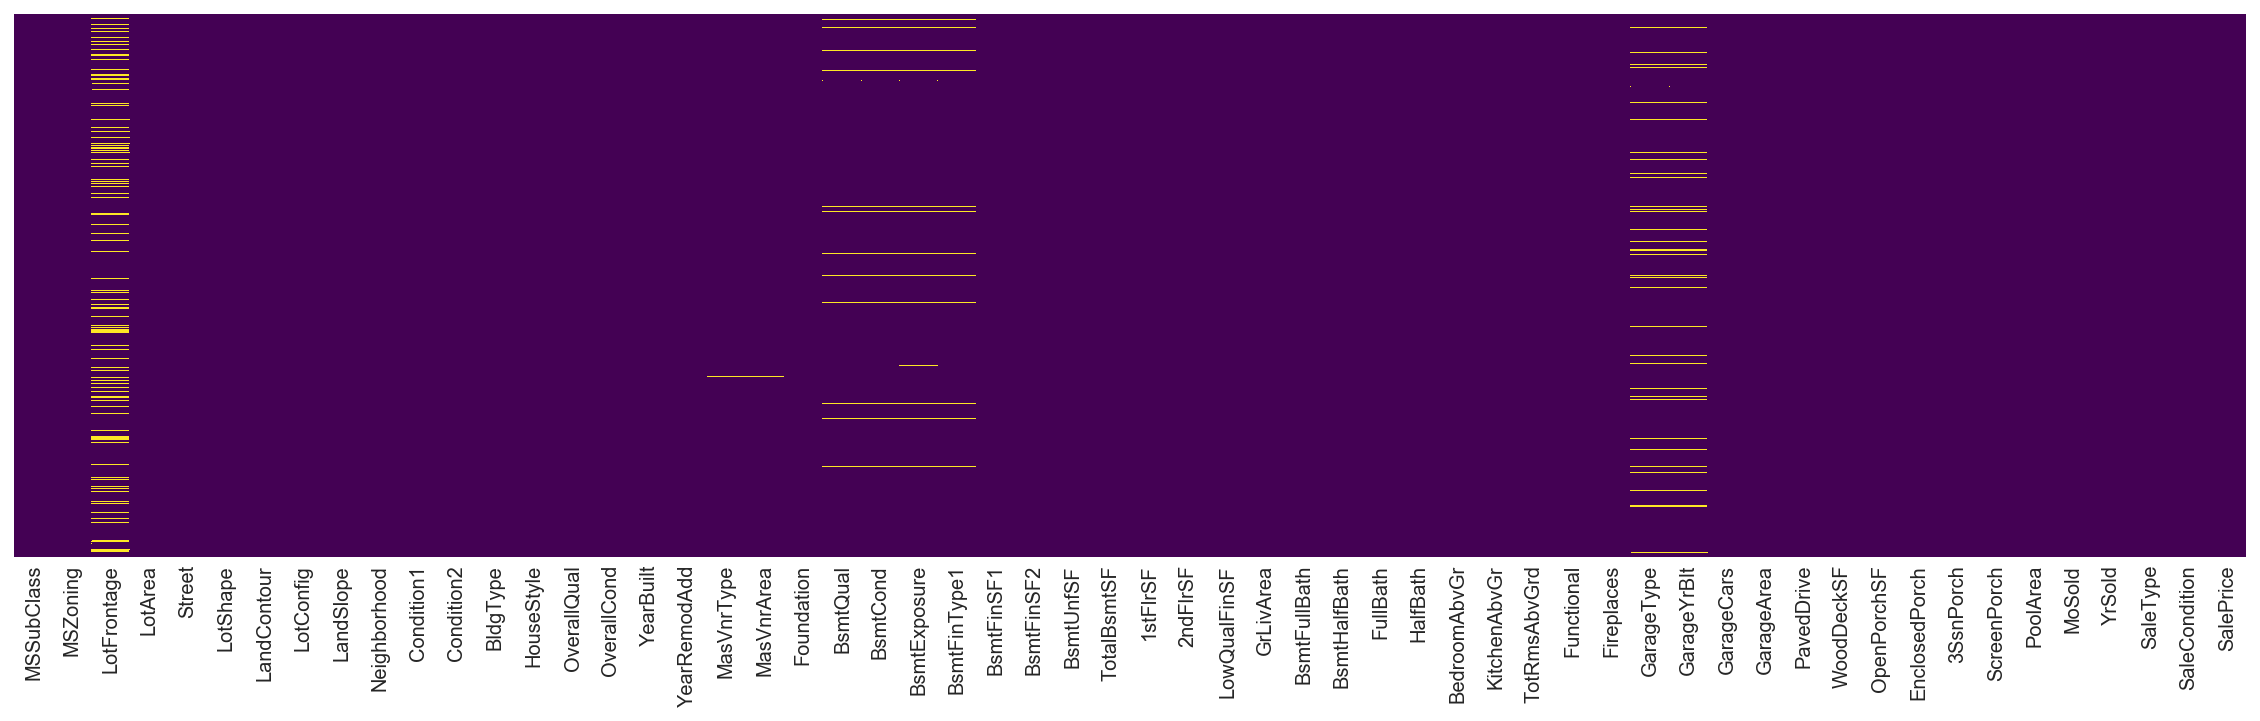

In [19]:
fig = plt.subplots(figsize=(20,5))
sns.heatmap(house.isnull(), yticklabels=False,cbar=False,cmap="viridis")

In [20]:
house.shape 

(1450, 58)

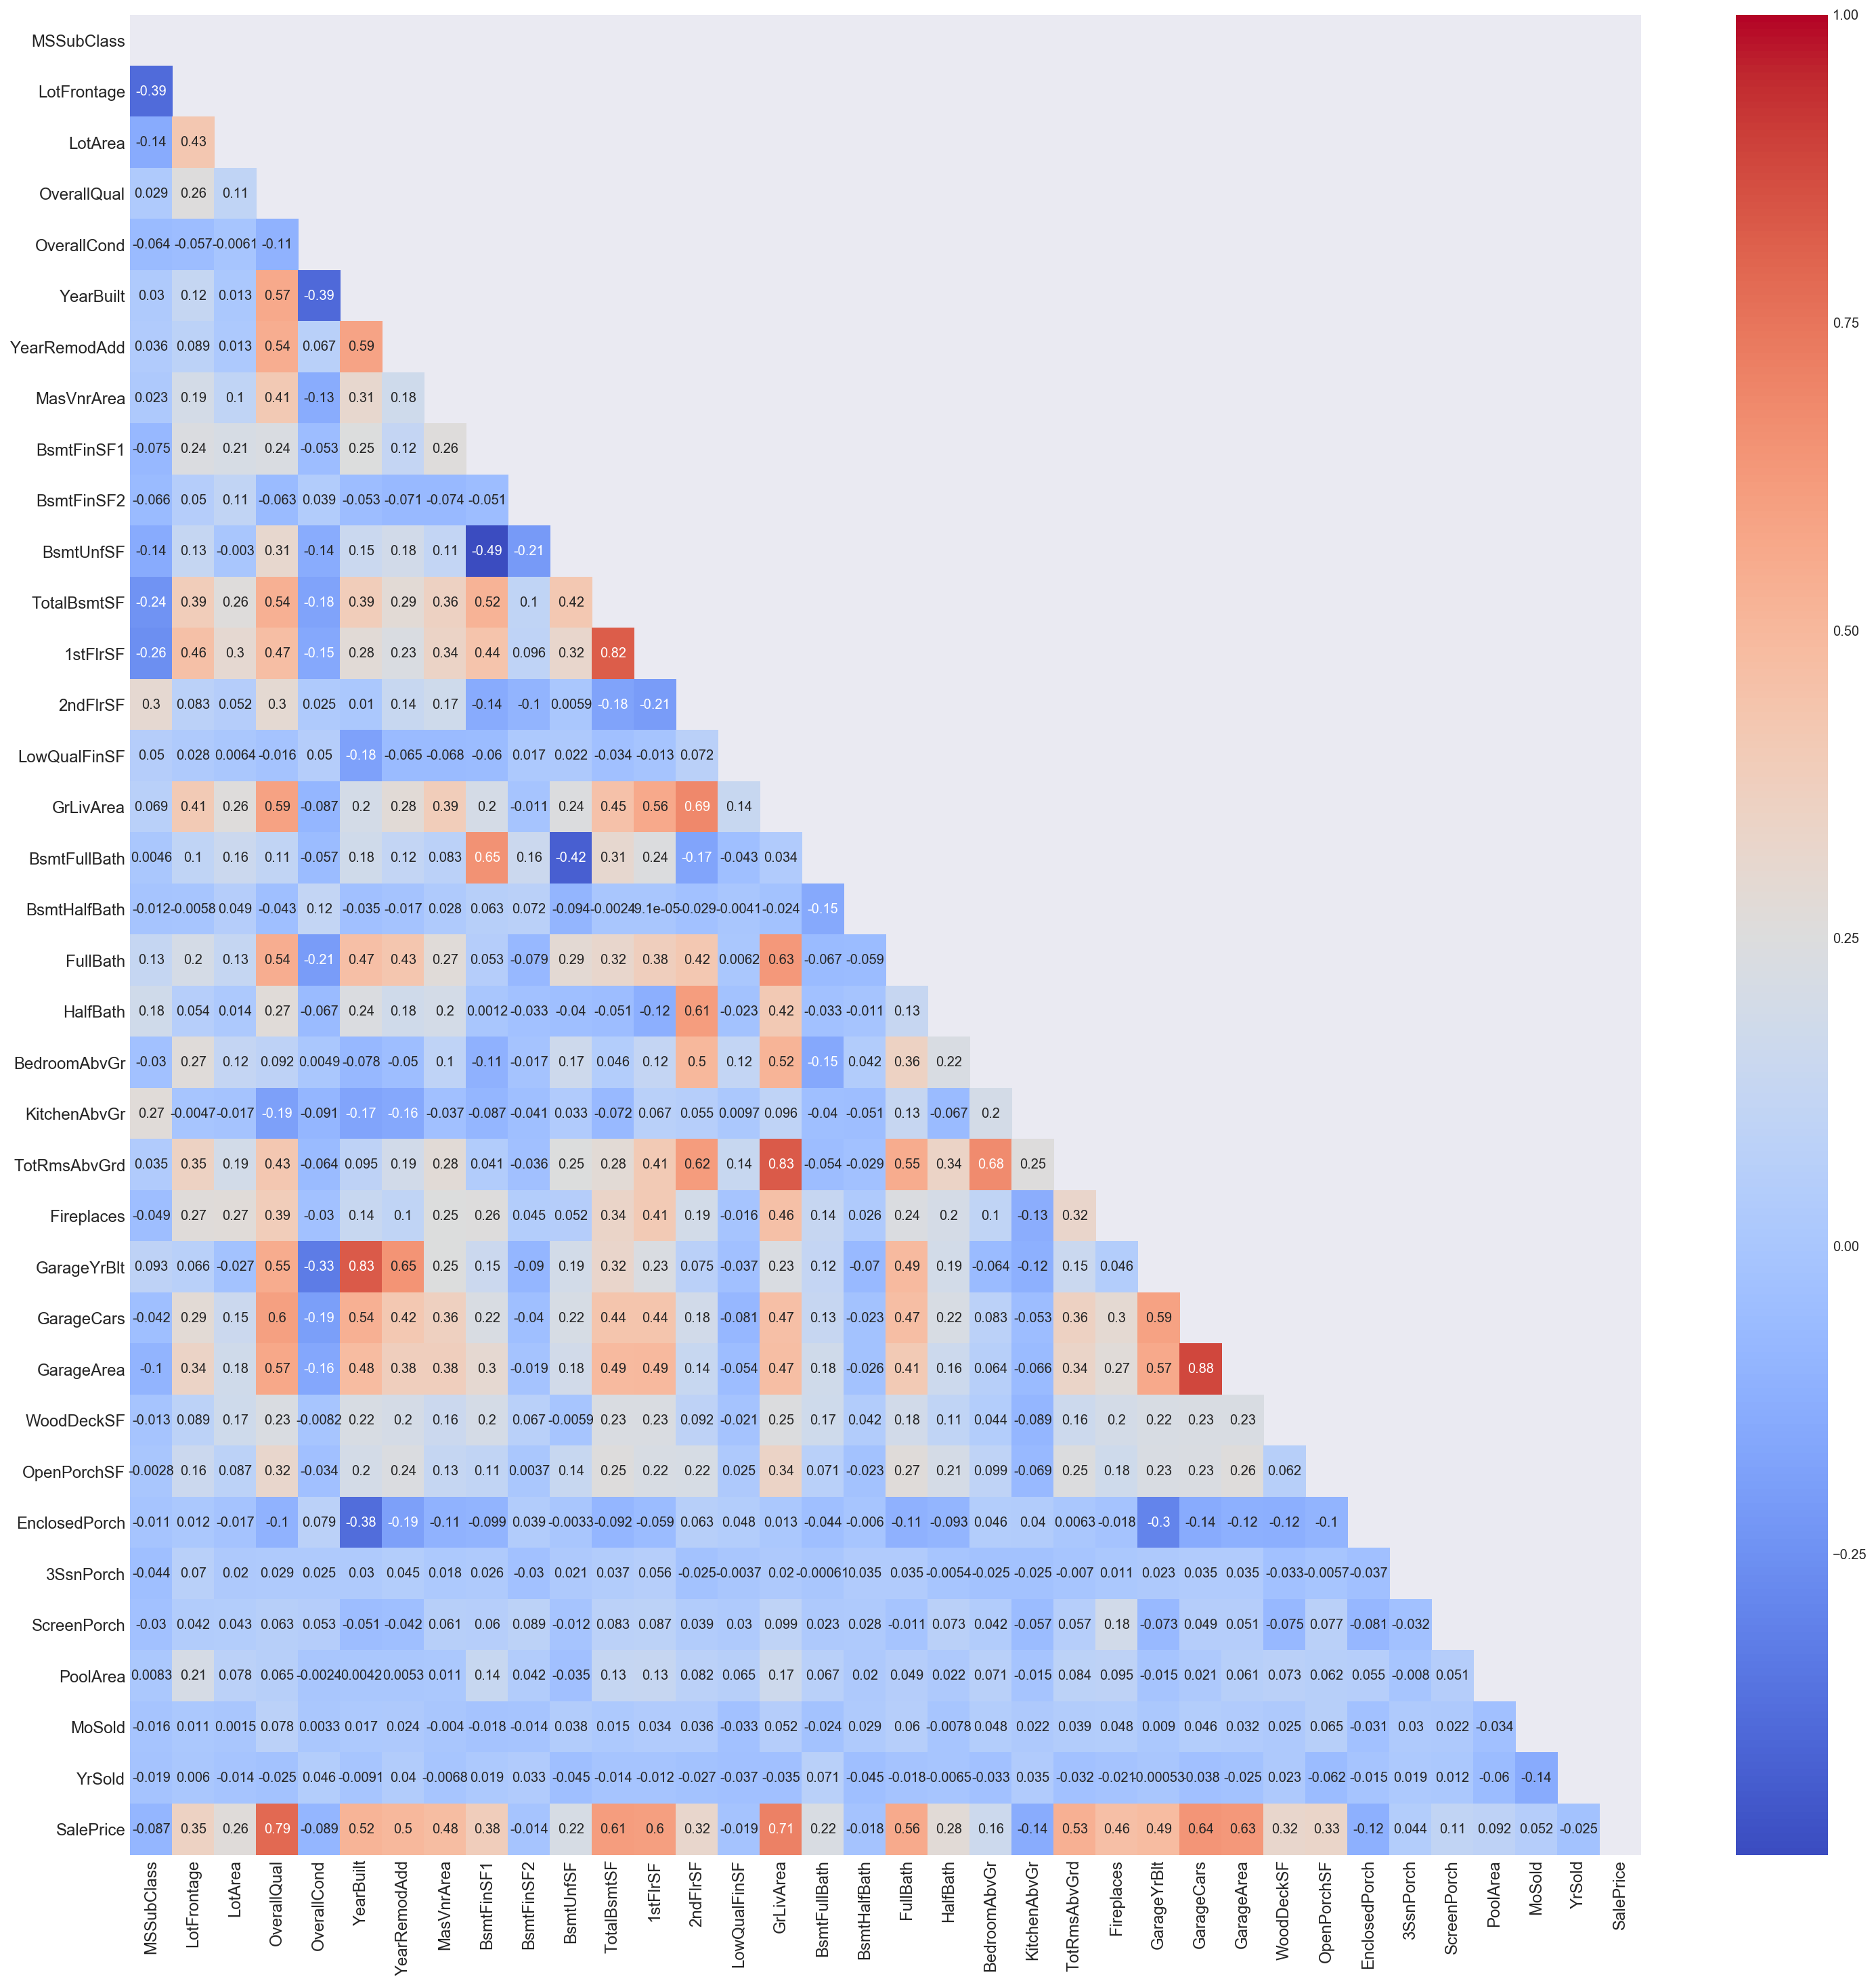

In [21]:
# Mapping HeatMap of House Corr.

housing_correlations = house.corr()

# Set the default matplotlib figure size:
fig, ax = plt.subplots(figsize=(25,25))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(housing_correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(housing_correlations, mask=mask, annot=True,cmap="coolwarm")

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=12, rotation=90)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=12, rotation=0)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()


In [22]:
#Reduce nos of Columns.
#Dropping columns based on heatmap corr.

house.drop(["GarageCars", "GarageYrBlt", "2ndFlrSF","TotalBsmtSF", "TotRmsAbvGrd"],axis=1,inplace=True)


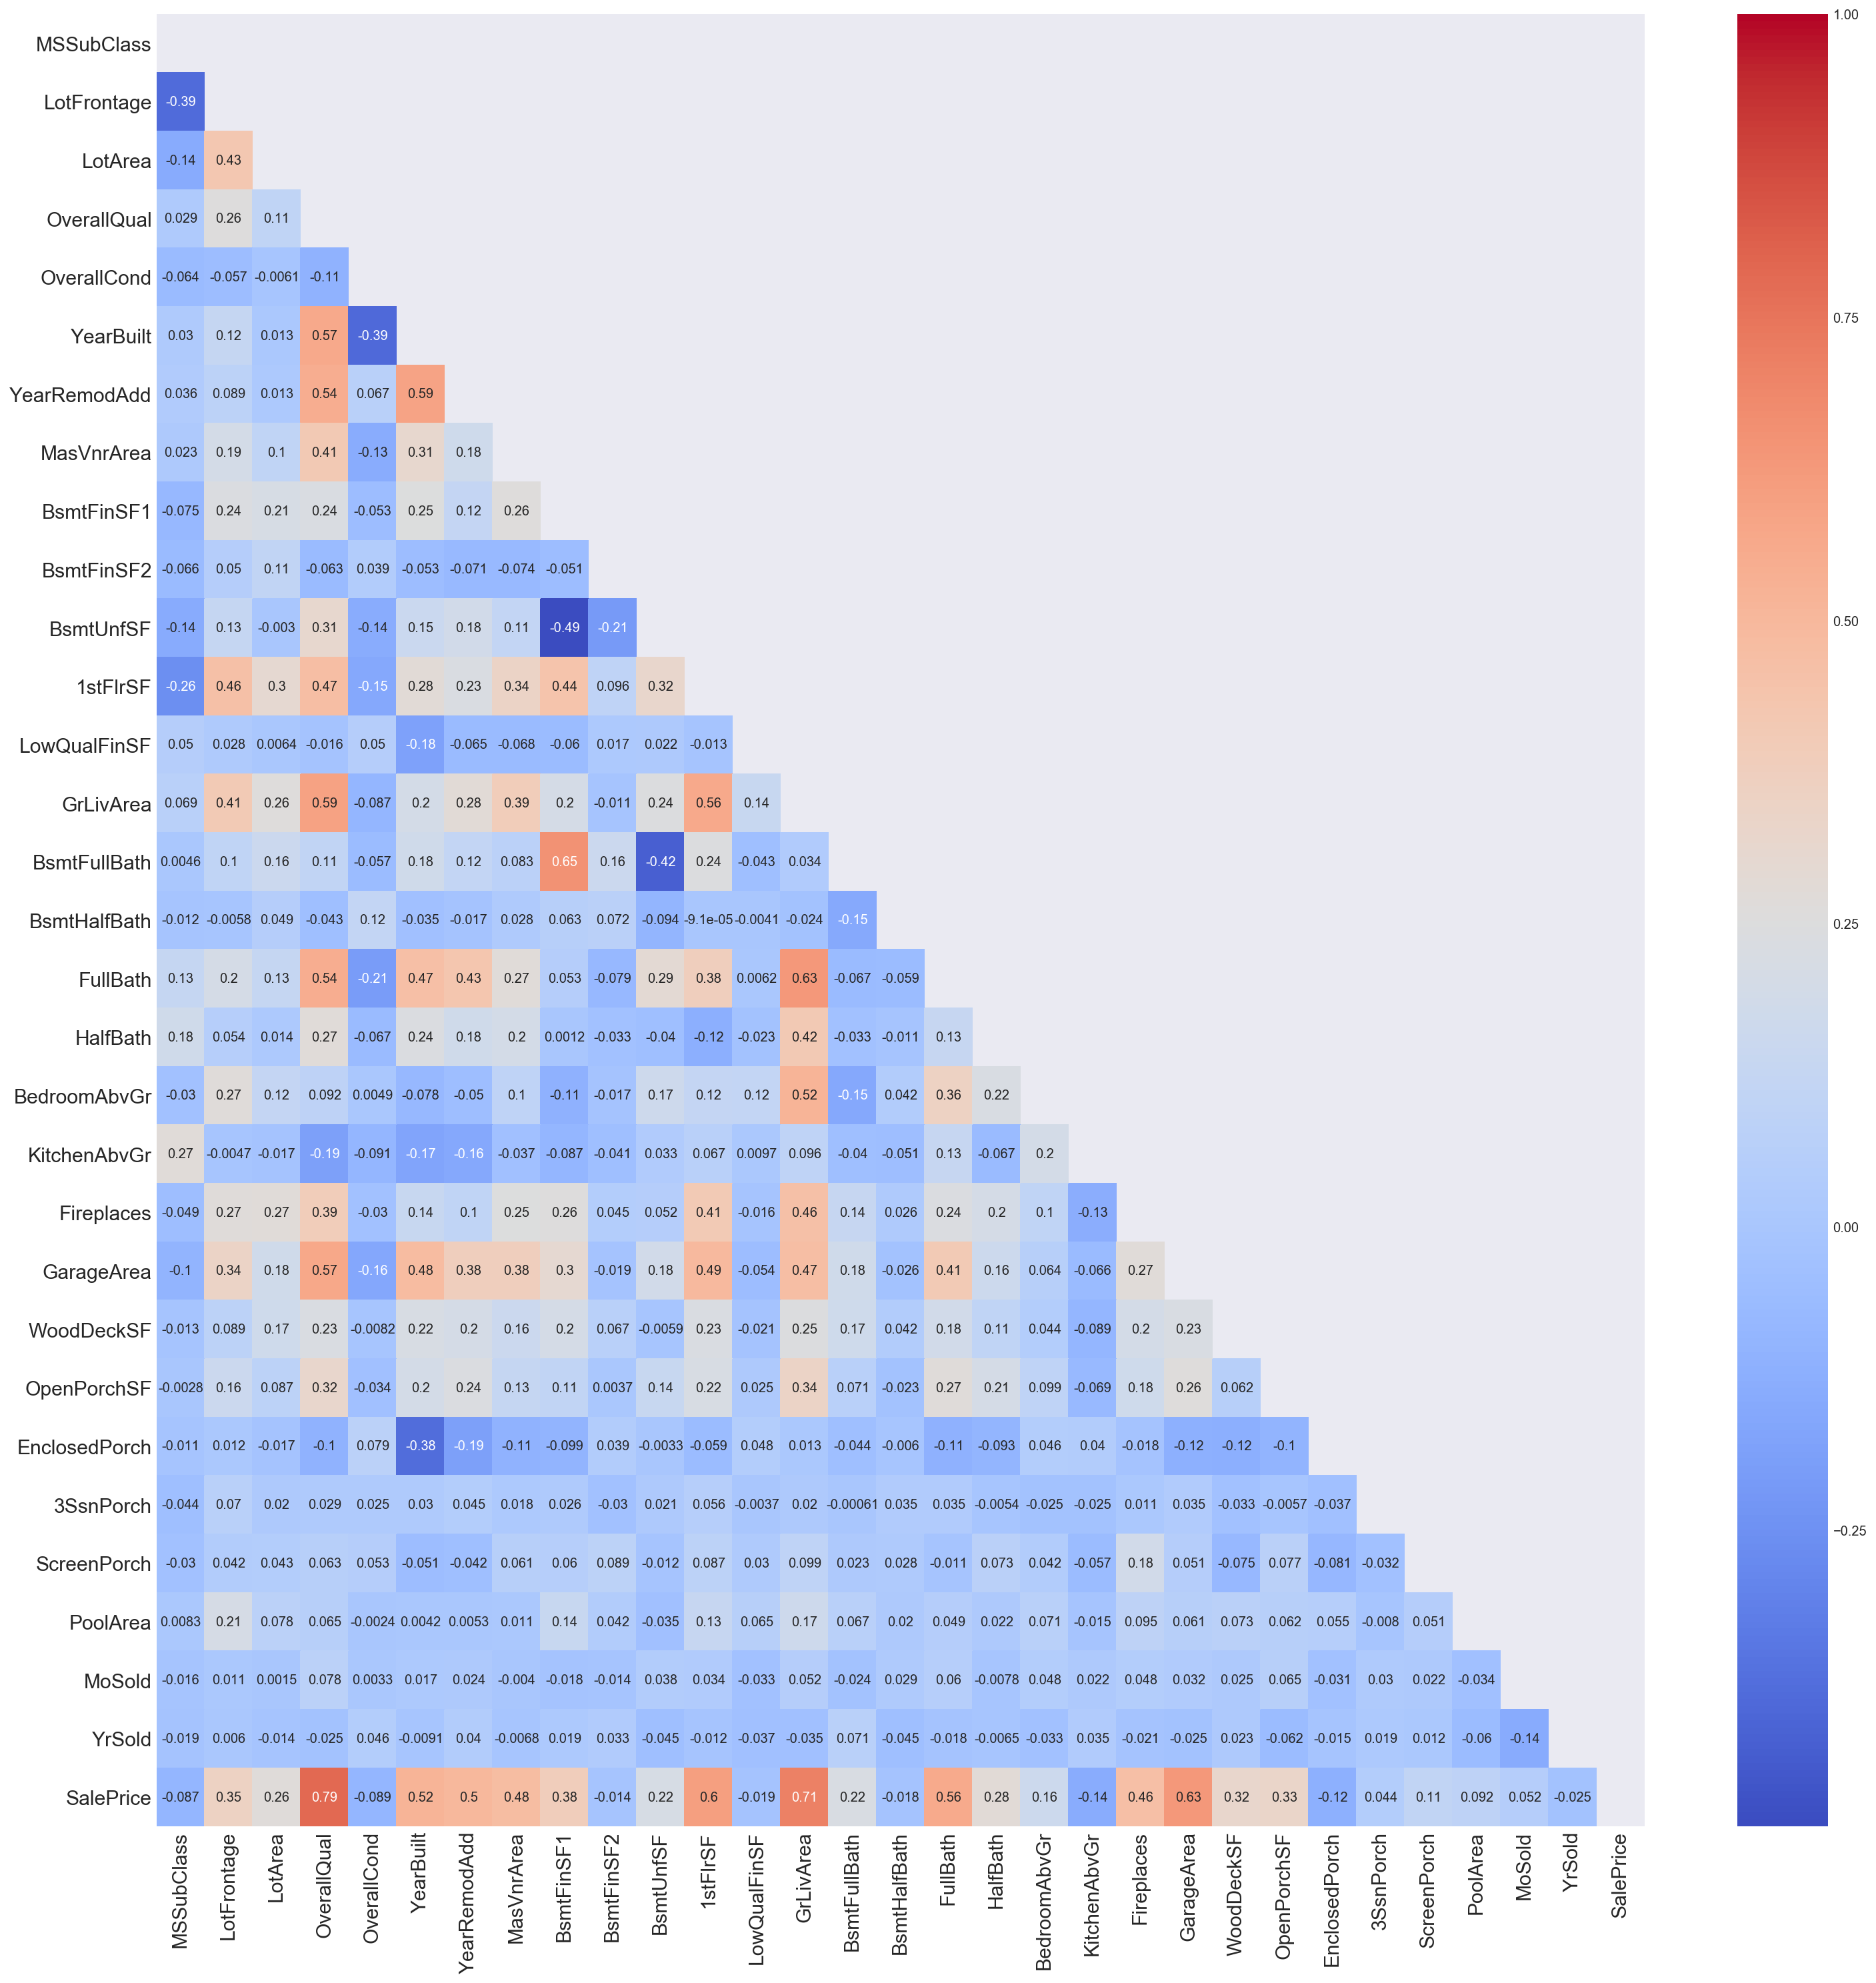

In [23]:
# Mapping HeatMap of House Corr.

housing_correlations = house.corr()

# Set the default matplotlib figure size:
fig, ax = plt.subplots(figsize=(25,25))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(housing_correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
#Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(housing_correlations, mask=mask, annot=True,cmap="coolwarm")

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=15, rotation=90)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=15, rotation=0)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()


In [24]:
# Final Number of Feature Drop....
house.shape

(1450, 53)

In [25]:
# Check for column with Nan....
house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 53 columns):
MSSubClass       1450 non-null int64
MSZoning         1450 non-null object
LotFrontage      1191 non-null float64
LotArea          1450 non-null int64
Street           1450 non-null object
LotShape         1450 non-null object
LandContour      1450 non-null object
LotConfig        1450 non-null object
LandSlope        1450 non-null object
Neighborhood     1450 non-null object
Condition1       1450 non-null object
Condition2       1450 non-null object
BldgType         1450 non-null object
HouseStyle       1450 non-null object
OverallQual      1450 non-null int64
OverallCond      1450 non-null int64
YearBuilt        1450 non-null int64
YearRemodAdd     1450 non-null int64
MasVnrType       1442 non-null object
MasVnrArea       1442 non-null float64
Foundation       1450 non-null object
BsmtQual         1413 non-null object
BsmtCond         1413 non-null object
BsmtExposure     1412 n

In [26]:
house.isnull().sum()

MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
LotShape           0
LandContour        0
LotConfig          0
LandSlope          0
Neighborhood       0
Condition1         0
Condition2         0
BldgType           0
HouseStyle         0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrType         8
MasVnrArea         8
Foundation         0
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
1stFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
Functional         0
Fireplaces         0
GarageType        79
GarageArea         0
PavedDrive         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea     

In [27]:
# Coverting the columns with "NaN" to either str variable
house.LotFrontage = house["LotFrontage"].map(lambda x : 0 if str(x) == 'nan' else x )
house.MasVnrType = house["MasVnrType"].map(lambda x : 'None' if str(x) == 'nan' else x )
house.MasVnrArea = house["MasVnrArea"].map(lambda x : 0 if str(x) == 'nan' else x )
house.BsmtQual = house["BsmtQual"].map(lambda x : 'None' if str(x) == 'nan' else x )
house.BsmtCond = house["BsmtCond"].map(lambda x : 'None' if str(x) == 'nan' else x )
house.BsmtExposure= house["BsmtExposure"].map(lambda x : 'No' if str(x) == 'nan' else x )
house.BsmtFinType1= house["BsmtFinType1"].map(lambda x : 'None' if str(x) == 'nan' else x )
house.GarageType= house["GarageType"].map(lambda x : 'None' if str(x) == 'nan' else x )


In [28]:
house.isnull().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
LotShape         0
LandContour      0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
MasVnrType       0
MasVnrArea       0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtUnfSF        0
1stFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
Functional       0
Fireplaces       0
GarageType       0
GarageArea       0
PavedDrive       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice   

In [29]:
# double check to confirm that no more null in the dataset.

colwmiss = []
missingval = []
for col in house.columns.tolist():
    if house[col].isnull().sum() > 0:
        colwmiss.append(col)
        missingval.append(house[col].isnull().sum())

zip(colwmiss,missingval)

[]

In [30]:
# Rename the "PoolArea" and changing the variable
#house.rename(columns={"PoolArea" : "PoolAvail"}, inplace = True)
#house.PoolAvail = house["PoolAvail"].map(lambda x : 1 if x != 0 else x )

In [31]:
# Rename the "Alley" and changing the variable
#house.rename(columns={"Fence" : "HaveFence"}, inplace = True)
#house.HaveFence = house["HaveFence"].map(lambda x : 1 if x == "MnPrv" or x=="GdPrv" or x == "GdWo" or x=='MnWw' else 0)

In [32]:
# Rename the "Alley" and changing the variable
#house.rename(columns={"Alley" : "HaveAlley"}, inplace = True)
#house.HaveAlley = house["HaveAlley"].map(lambda x : 1 if x == "Grvl" or x=="Pave" else 0)

In [33]:
# Reduce nos of Colums...Dropping features lesa than 20%
#house.drop(["PoolQC", "MiscVal","MiscFeature"],axis=1,inplace=True)

In [34]:
# Question 1.3
# renaming of col name for use in patsy
house.rename(columns={"3SsnPorch" : "SsnPorch"}, inplace = True)
house.rename(columns={"1stFlrSF" : "OnestFlrSF"}, inplace = True)


In [35]:
# Use for Question Linear Regresssion.

Feature ="SalePrice ~ "+" +".join([c for c in house.columns if not c=="SalePrice"])
print Feature

SalePrice ~ MSSubClass +MSZoning +LotFrontage +LotArea +Street +LotShape +LandContour +LotConfig +LandSlope +Neighborhood +Condition1 +Condition2 +BldgType +HouseStyle +OverallQual +OverallCond +YearBuilt +YearRemodAdd +MasVnrType +MasVnrArea +Foundation +BsmtQual +BsmtCond +BsmtExposure +BsmtFinType1 +BsmtFinSF1 +BsmtFinSF2 +BsmtUnfSF +OnestFlrSF +LowQualFinSF +GrLivArea +BsmtFullBath +BsmtHalfBath +FullBath +HalfBath +BedroomAbvGr +KitchenAbvGr +Functional +Fireplaces +GarageType +GarageArea +PavedDrive +WoodDeckSF +OpenPorchSF +EnclosedPorch +SsnPorch +ScreenPorch +PoolArea +MoSold +YrSold +SaleType +SaleCondition


In [36]:
# using pasty to increase col. # do not understand ask bernard on Monday#
import patsy

y,X = patsy.dmatrices (Feature, data=house, return_type ="dataframe")
y=y.values.ravel()

In [37]:
X.head()

,Intercept,MSZoning[T.RH],MSZoning[T.RL],MSZoning[T.RM],Street[T.Pave],LotShape[T.IR2],LotShape[T.IR3],LotShape[T.Reg],LandContour[T.HLS],LandContour[T.Low],...,Fireplaces,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,SsnPorch,ScreenPorch,PoolArea,MoSold,YrSold
0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,548.0,0.0,61.0,0.0,0.0,0.0,0.0,2.0,2008.0
1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,460.0,298.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0
2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,608.0,0.0,42.0,0.0,0.0,0.0,0.0,9.0,2008.0
3,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,642.0,0.0,35.0,272.0,0.0,0.0,0.0,2.0,2006.0
4,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,836.0,192.0,84.0,0.0,0.0,0.0,0.0,12.0,2008.0


In [38]:
X.shape

(1450, 149)

In [39]:
y.shape

(1450,)

In [40]:
#checking mean price
print np.mean(y)

181654.942069


In [41]:
# Setting up training Set
X_train = X[X['YrSold']!=2010]
y_train = y[X['YrSold']!=2010]

# Setting up Testing Set
X_test = X[X['YrSold'] == 2010]
y_test = y[X['YrSold'] == 2010]

# Print all x & Y Shape to verify size
print X_train.shape,y_train.shape,X_test.shape,y_test.shape

(1278, 149) (1278,) (172, 149) (172,)


In [42]:
# Standardization process of X and Y information before fitting into model

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
Xs = scaler.transform(X_train)
Xt = scaler.transform(X_test)

#from sklearn.preprocessing  import StandardScaler
#ss =StandardScaler()
#XT = ss.fit_transform(X)

In [43]:
# Input Linear Regression model processes

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lr=LinearRegression()
lr.fit(Xs,y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [44]:
# The Y Intercept " BETA 0 " Output. 
print (lr.intercept_)

181989.782473


In [45]:
# The the "BETA Xn" or Coefficient (weights) for Linear Function

cfd =pd.DataFrame(lr.coef_,X_train.columns,columns =["coeff"])
cfd

,coeff
Intercept,2.367744e+11
MSZoning[T.RH],-3.815369e+02
MSZoning[T.RL],-8.861500e+02
MSZoning[T.RM],-1.100609e+03
Street[T.Pave],1.389678e+03
LotShape[T.IR2],1.406147e+03
LotShape[T.IR3],-3.094941e+03
LotShape[T.Reg],9.228017e+02
LandContour[T.HLS],2.758302e+03
LandContour[T.Low],1.067817e+03


In [46]:
# The Predicted Y_hat Value (Estimated)
Pred =lr.predict(Xt) # Using X_test value


In [47]:
type(Pred)

numpy.ndarray

In [48]:
Pred.shape

(172,)

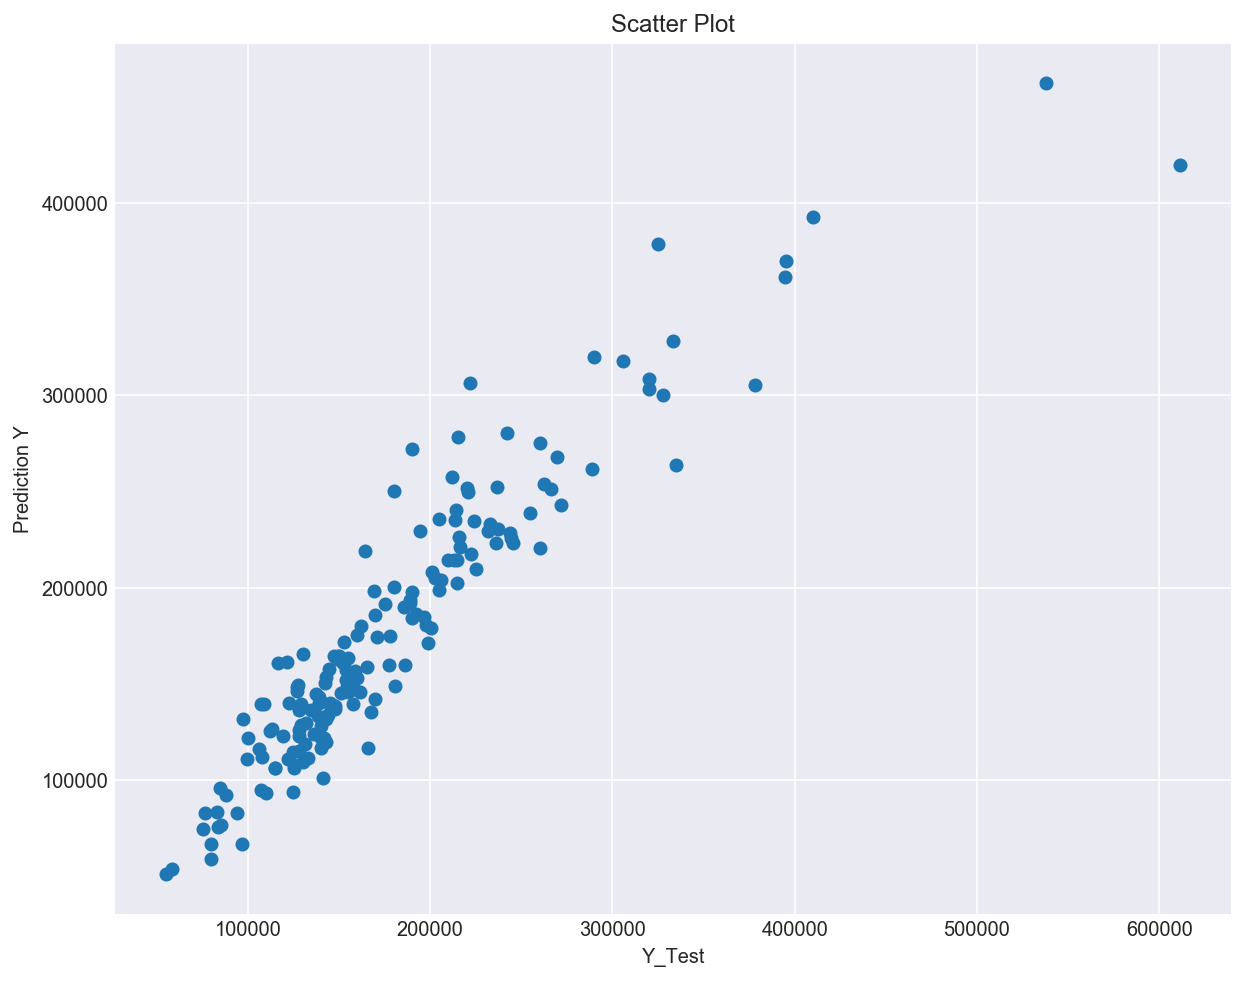

In [50]:
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(y_test,Pred)


# Customization scale and label
ax.set_title("Scatter Plot")
ax.set_xlabel ("Y_Test")
ax.set_ylabel ("Prediction Y")



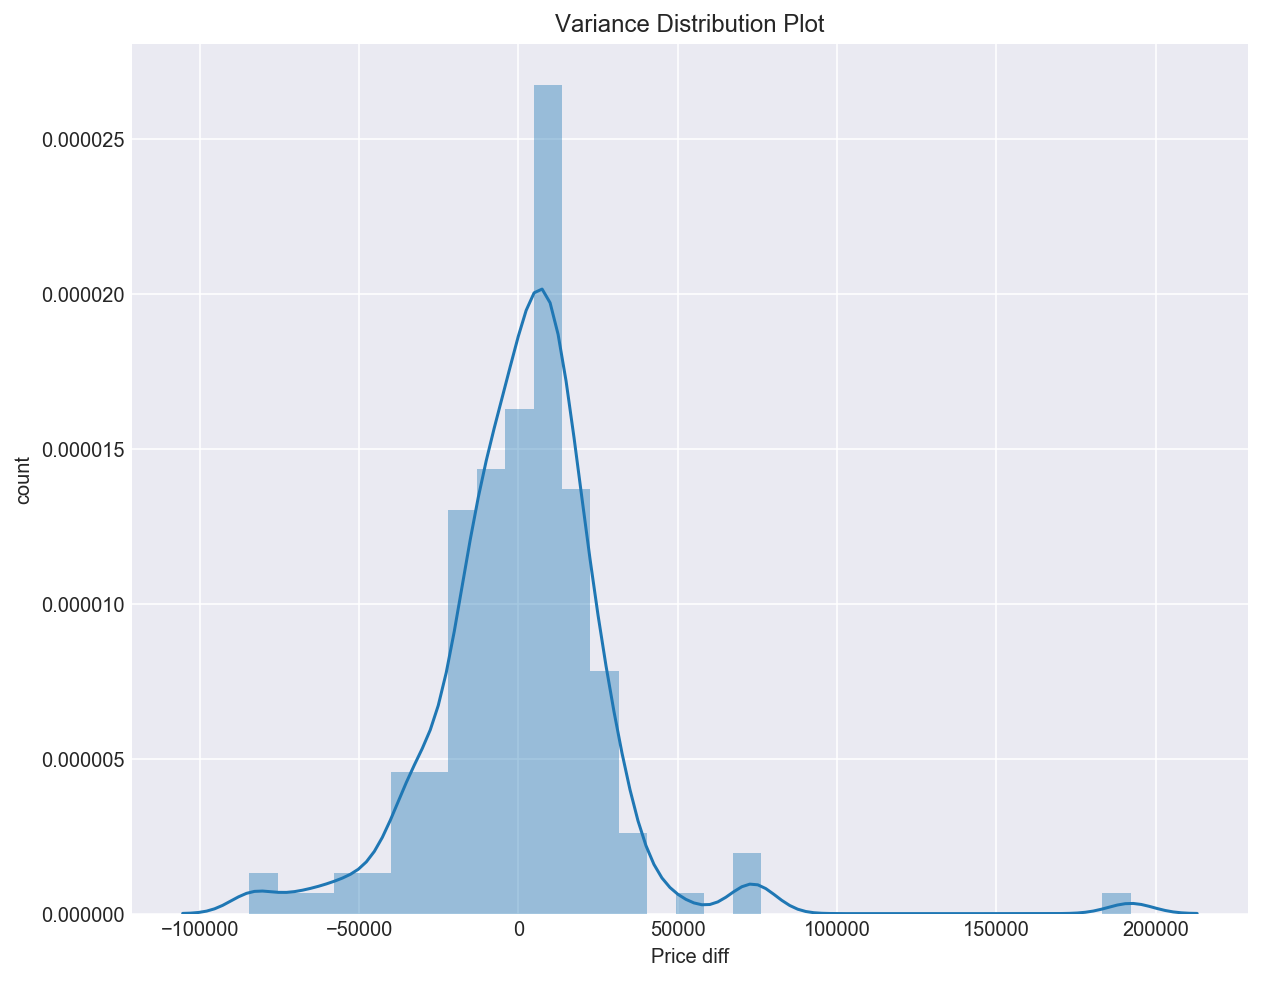

In [52]:
fig, ax = plt.subplots(figsize=(10,8))
sns.distplot((y_test - Pred))

# Customization scale and label
ax.set_title("Variance Distribution Plot")
ax.set_xlabel ("Price diff")
ax.set_ylabel ("count")

In [53]:
from sklearn import metrics

# LINEAR REGRESSION METRICS....

# Calculate and print metrics
print "Mean Abs Error :", metrics.mean_absolute_error(y_test,Pred),"Mean Sqr_Error :" ,metrics.mean_squared_error(y_test,Pred), "Mean_Root Sqr Error:",np.sqrt(metrics.mean_squared_error(y_test,Pred))

# Calculate and print score
print "Linear Regression Score :", lr.score(Xt,y_test)

# Calculate mean of 
print "Y_hat_Mean(lr) :" ,np.mean(Pred)

Mean Abs Error : 18594.851472 Mean Sqr_Error : 786367781.495 Mean_Root Sqr Error: 28042.2499364
Linear Regression Score : 0.876306683149
Y_hat_Mean(lr) : 177840.628039


In [54]:
# Linear Regression Cross Val....

from sklearn.model_selection import cross_val_score

reg_scores = cross_val_score(LinearRegression(), Xs, y_train, cv=5)
print "Linear Regression Score :",reg_scores
print "Linear Mean Score :",np.mean(reg_scores)


Linear Regression Score : [  8.84573555e-01  -8.58575290e+19  -4.54587488e+20  -4.38365902e+20
  -1.10778998e+20]
Linear Mean Score : -2.17917983289e+20


In [55]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV

# Running LASSO Model

las1=Lasso(alpha=100)
las1.fit(Xs, y_train)

Pred2=las1.predict(Xt)

print "LASSO Score :",las1.score(Xt,y_test)


LASSO Score : 0.878306633997


In [56]:
# LASSO Cross Val......

reg_scores1= cross_val_score(Lasso(), Xs, y_train, cv=5)
print "LASSO Score(per k-fold) :", reg_scores1
print "LASSO Mean Score :" , np.mean(reg_scores1)

LASSO Score(per k-fold) : [ 0.88472565  0.81254916  0.81494327  0.83482371  0.67560528]
LASSO Mean Score : 0.80452941459


In [57]:
las1_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':las1.coef_,
                            'abs_coef':np.abs(las1.coef_)})

las1_coefs.sort_values('abs_coef', inplace=True, ascending=False)

x= las1_coefs[las1_coefs.coef==0]

In [58]:
las1_coefs

,abs_coef,coef,variable
132,33321.274419,33321.274419,GrLivArea
76,17154.523245,-17154.523245,BsmtQual[T.Gd]
122,15971.141297,15971.141297,OverallQual
78,15849.610675,-15849.610675,BsmtQual[T.TA]
32,9556.527780,9556.527780,Neighborhood[T.NridgHt]
31,8886.685967,8886.685967,Neighborhood[T.NoRidge]
52,6818.809179,-6818.809179,Condition2[T.PosN]
61,6492.445352,6492.445352,HouseStyle[T.1Story]
38,6394.780734,6394.780734,Neighborhood[T.StoneBr]
119,6070.334969,-6070.334969,MSSubClass


In [59]:
x

,abs_coef,coef,variable
143,0.0,0.0,EnclosedPorch
0,0.0,0.0,Intercept
129,0.0,0.0,BsmtUnfSF
118,0.0,0.0,SaleCondition[T.Partial]
116,0.0,0.0,SaleCondition[T.Family]
110,0.0,0.0,SaleType[T.ConLw]
94,0.0,-0.0,Functional[T.Min2]
93,0.0,-0.0,Functional[T.Min1]
86,0.0,-0.0,BsmtFinType1[T.BLQ]
79,0.0,-0.0,BsmtCond[T.Gd]


In [60]:
# Running Ridge Model

Rig1=Ridge(alpha=100)
Rig1.fit(Xs, y_train)

Pred3=Rig1.predict(Xt)

print "RIDGE Score :",Rig1.score(Xt,y_test)


RIDGE Score : 0.875155710718


In [61]:
# RIDGE Cross Val......
reg_scores2= cross_val_score(Ridge(), Xs, y_train, cv=5)
print "RIDGE Score(per k-fold) :", reg_scores2
print "RIDGE Mean Score :" , np.mean(reg_scores2)


RIDGE Score(per k-fold) : [ 0.88523201  0.81325991  0.81540562  0.83582252  0.67607086]
RIDGE Mean Score : 0.805158182093


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [62]:
# Regression for Training set.
lr=LinearRegression()
Pred4 = lr.fit(Xs,y_train).predict(Xs)

In [63]:
type(Pred4)

numpy.ndarray

In [64]:
X_train.tail()

,Intercept,MSZoning[T.RH],MSZoning[T.RL],MSZoning[T.RM],Street[T.Pave],LotShape[T.IR2],LotShape[T.IR3],LotShape[T.Reg],LandContour[T.HLS],LandContour[T.Low],...,Fireplaces,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,SsnPorch,ScreenPorch,PoolArea,MoSold,YrSold
1452,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,525.0,0.0,28.0,0.0,0.0,0.0,0.0,5.0,2006.0
1453,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,36.0,56.0,0.0,0.0,0.0,0.0,7.0,2006.0
1454,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,400.0,0.0,113.0,0.0,0.0,0.0,0.0,10.0,2009.0
1455,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,460.0,0.0,40.0,0.0,0.0,0.0,0.0,8.0,2007.0
1459,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,276.0,736.0,68.0,0.0,0.0,0.0,0.0,6.0,2008.0


In [65]:
len(renovatable)

17

In [66]:
#Reduce nos of Rows by 10 nos for Non residential house from orginal dataset_house2.
house2=house2[house2["MSZoning"]!="C (all)"] 

In [67]:
print type(house2[renovatable + ['YrSold']])

<class 'pandas.core.frame.DataFrame'>


In [68]:
housenew = house2[renovatable + ['YrSold']]

In [69]:
housenew.shape

(1450, 18)

In [70]:
housenew.isnull().sum()

Utilities         0
RoofStyle         0
RoofMatl          0
Exterior1st       0
Exterior2nd       0
ExterQual         0
ExterCond         0
BsmtFinType2     38
Heating           0
HeatingQC         0
CentralAir        0
Electrical        1
KitchenQual       0
FireplaceQu     681
GarageFinish     79
GarageQual       79
GarageCond       79
YrSold            0
dtype: int64

In [71]:
housenew.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 18 columns):
Utilities       1450 non-null object
RoofStyle       1450 non-null object
RoofMatl        1450 non-null object
Exterior1st     1450 non-null object
Exterior2nd     1450 non-null object
ExterQual       1450 non-null object
ExterCond       1450 non-null object
BsmtFinType2    1412 non-null object
Heating         1450 non-null object
HeatingQC       1450 non-null object
CentralAir      1450 non-null object
Electrical      1449 non-null object
KitchenQual     1450 non-null object
FireplaceQu     769 non-null object
GarageFinish    1371 non-null object
GarageQual      1371 non-null object
GarageCond      1371 non-null object
YrSold          1450 non-null int64
dtypes: int64(1), object(17)
memory usage: 215.2+ KB


In [72]:
# Check item for "nan"

print housenew.BsmtFinType2.unique()
print housenew.FireplaceQu.unique()
print housenew.GarageFinish.unique()
print housenew.GarageQual.unique()
print housenew.GarageCond.unique()
print housenew.Electrical .unique()

['Unf' 'BLQ' nan 'ALQ' 'Rec' 'LwQ' 'GLQ']
[nan 'TA' 'Gd' 'Fa' 'Ex' 'Po']
['RFn' 'Unf' 'Fin' nan]
['TA' 'Fa' 'Gd' nan 'Ex' 'Po']
['TA' nan 'Gd' 'Fa' 'Po' 'Ex']
['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix' nan]


In [73]:
# Remove all "nan" from column

housenew.BsmtFinType2 = housenew["BsmtFinType2"].map(lambda x : 'None' if str(x) == 'nan' else x )
housenew.FireplaceQu =  housenew["FireplaceQu"].map(lambda x : 'None' if str(x) == 'nan' else x )
housenew.GarageFinish = housenew["GarageFinish"].map(lambda x : 'None' if str(x) == 'nan' else x )
housenew.GarageQual = housenew["GarageQual"].map(lambda x : 'None' if str(x) == 'nan' else x )
housenew.GarageCond = housenew["GarageCond"].map(lambda x : 'None' if str(x) == 'nan' else x )
housenew.Electrical = housenew["Electrical"].map(lambda x : 'None' if str(x) == 'nan' else x )


/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [74]:
housenew.isnull().sum()

Utilities       0
RoofStyle       0
RoofMatl        0
Exterior1st     0
Exterior2nd     0
ExterQual       0
ExterCond       0
BsmtFinType2    0
Heating         0
HeatingQC       0
CentralAir      0
Electrical      0
KitchenQual     0
FireplaceQu     0
GarageFinish    0
GarageQual      0
GarageCond      0
YrSold          0
dtype: int64

In [75]:
Feature2 ="~"+" +".join([c for c in housenew.columns if not c=="SalePrice"])+ " - 1"
print Feature2

~Utilities +RoofStyle +RoofMatl +Exterior1st +Exterior2nd +ExterQual +ExterCond +BsmtFinType2 +Heating +HeatingQC +CentralAir +Electrical +KitchenQual +FireplaceQu +GarageFinish +GarageQual +GarageCond +YrSold - 1


In [76]:
X1 = patsy.dmatrix(Feature2, data=housenew, return_type ="dataframe")

In [77]:
X1.head()

,Utilities[AllPub],Utilities[NoSeWa],RoofStyle[T.Gable],RoofStyle[T.Gambrel],RoofStyle[T.Hip],RoofStyle[T.Mansard],RoofStyle[T.Shed],RoofMatl[T.CompShg],RoofMatl[T.Membran],RoofMatl[T.Metal],...,GarageQual[T.Gd],GarageQual[T.None],GarageQual[T.Po],GarageQual[T.TA],GarageCond[T.Fa],GarageCond[T.Gd],GarageCond[T.None],GarageCond[T.Po],GarageCond[T.TA],YrSold
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2008.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2007.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2008.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2006.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2008.0


In [78]:
#Splitting between X_train and X_test
X_train1 = X[X['YrSold']!=2010]
X_test1 = X[X['YrSold'] == 2010]

In [79]:
X_train1.shape,X_test1.shape

((1278, 149), (172, 149))

In [80]:
# Scale the values in dataframe
scaler = StandardScaler().fit(X_train1)
Xs1 = scaler.transform(X_train1)
Xt1 = scaler.transform(X_test1)

In [81]:
# Residual for Y_train and Y_test
Res_ytrain =(Pred4 - y_train)
Res_ytest=(Pred - y_test)

In [82]:
# Linear Regression for Renovatable
lrreno=LinearRegression()
Pred5=lrreno.fit(Xs1,Res_ytrain).predict(Xt1)

print lrreno.score(Xt1,Res_ytest)

-0.00237210002688


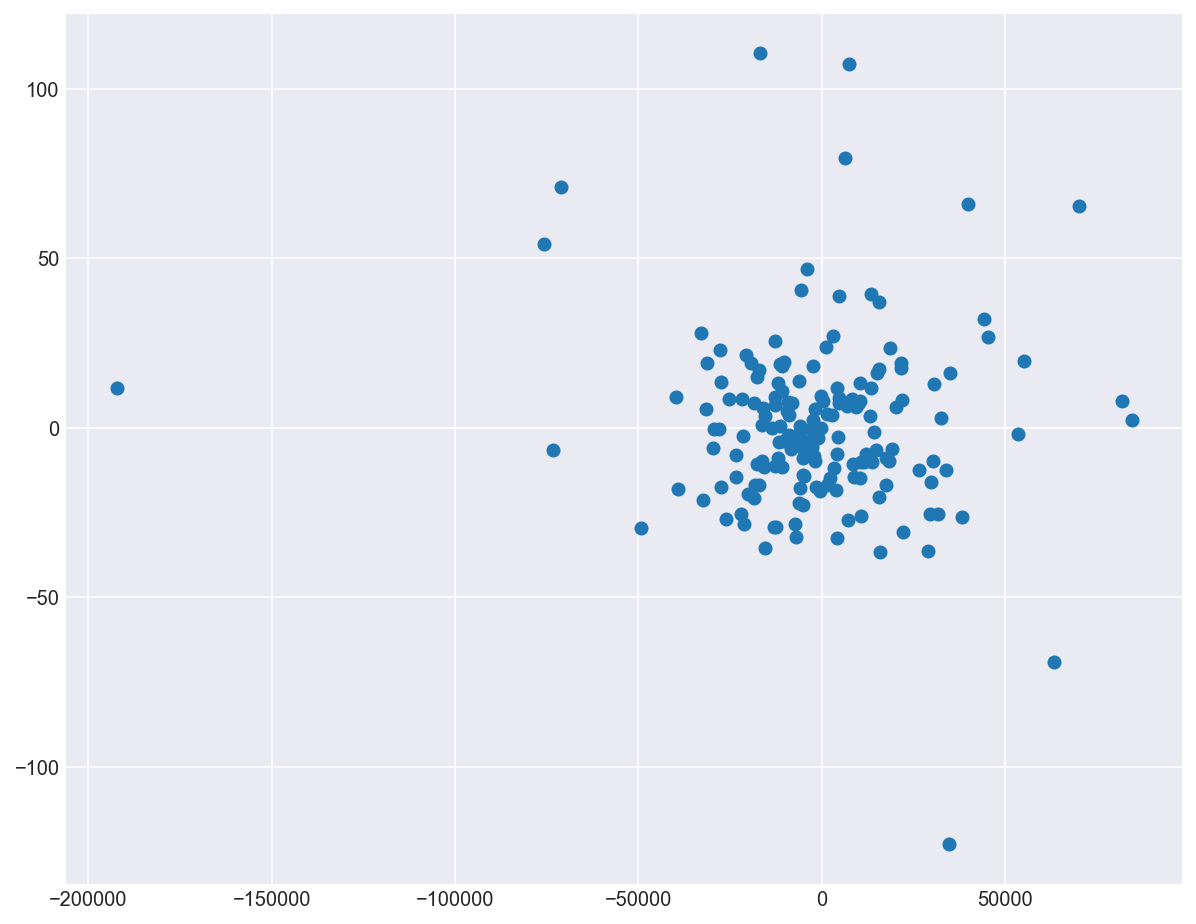

In [85]:
fig, ax_1 = plt.subplots(figsize=(10,8))
ax_1.scatter(Res_ytest,Pred5)

# Customization scale and label
ax.set_title("Scatter Plot")
ax.set_xlabel ("Y_Test")
ax.set_ylabel ("Prediction Y")

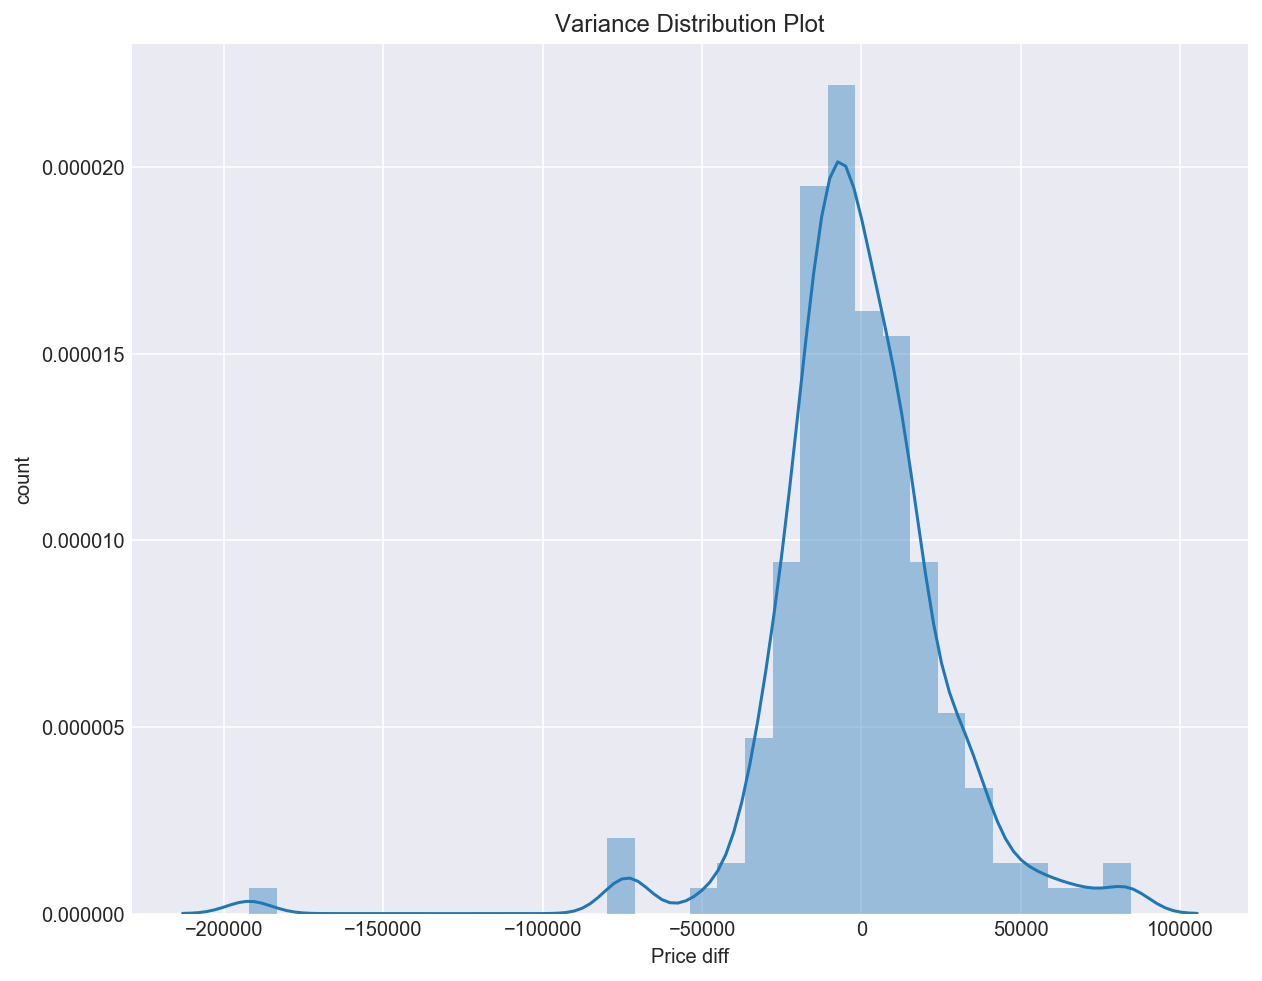

In [86]:
fig, ax = plt.subplots(figsize=(10,8))
sns.distplot((Res_ytest - Pred5))

ax.set_title("Variance Distribution Plot")
ax.set_xlabel ("Price diff")
ax.set_ylabel ("count")



In [87]:
print metrics.mean_absolute_error(Res_ytest,Pred5)
print metrics.mean_squared_error(Res_ytest,Pred5)
print np.sqrt(metrics.mean_squared_error(Res_ytest,Pred5))
print np.std(Res_ytest)
print np.mean(Res_ytest)

18594.4475688
786469688.804
28044.0669091
28010.8643015
-1326.37196134


In [88]:
# LASSO Regression for Renovatable

lasreno=Lasso(alpha=5)
Pred6=lasreno.fit(Xs1, Res_ytrain).predict(Xt1)

print lasreno.score(Xt1,Res_ytest)

-0.00224094933856


In [89]:
# RIDGE REgression for renovatable

Rigreno=Ridge(alpha=5)
Pred6=Rigreno.fit(Xs1, Res_ytrain).predict(Xt1)

print Rigreno.score(Xt1,Res_ytest)

-0.00222682639798


In [90]:
# Second model should not be consider as perform worst than baseline and seem like renovatable have minimum impact to
# model.
# Model 1 seem to have better chance in predicting the price od the house.
# No relationship to explaining for price variance.
# Model seem unrealiable , hence use only at your own risk.....

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [91]:
# A:
house3 = house.copy()

In [92]:
house3.SaleCondition = house3["SaleCondition"].map(lambda x : 1 if x =='Abnorml' else 0 )

In [93]:
house3.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,...,OpenPorchSF,EnclosedPorch,SsnPorch,ScreenPorch,PoolArea,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,Inside,Gtl,CollgCr,...,61,0,0,0,0,2,2008,WD,0,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,FR2,Gtl,Veenker,...,0,0,0,0,0,5,2007,WD,0,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,Inside,Gtl,CollgCr,...,42,0,0,0,0,9,2008,WD,0,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,Corner,Gtl,Crawfor,...,35,272,0,0,0,2,2006,WD,1,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,FR2,Gtl,NoRidge,...,84,0,0,0,0,12,2008,WD,0,250000


In [94]:
house3.SaleCondition.unique()

array([0, 1])

In [95]:
house3.shape

(1450, 53)

In [96]:
house3

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,...,OpenPorchSF,EnclosedPorch,SsnPorch,ScreenPorch,PoolArea,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,Inside,Gtl,CollgCr,...,61,0,0,0,0,2,2008,WD,0,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,FR2,Gtl,Veenker,...,0,0,0,0,0,5,2007,WD,0,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,Inside,Gtl,CollgCr,...,42,0,0,0,0,9,2008,WD,0,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,Corner,Gtl,Crawfor,...,35,272,0,0,0,2,2006,WD,1,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,FR2,Gtl,NoRidge,...,84,0,0,0,0,12,2008,WD,0,250000
5,50,RL,85.0,14115,Pave,IR1,Lvl,Inside,Gtl,Mitchel,...,30,0,320,0,0,10,2009,WD,0,143000
6,20,RL,75.0,10084,Pave,Reg,Lvl,Inside,Gtl,Somerst,...,57,0,0,0,0,8,2007,WD,0,307000
7,60,RL,0.0,10382,Pave,IR1,Lvl,Corner,Gtl,NWAmes,...,204,228,0,0,0,11,2009,WD,0,200000
8,50,RM,51.0,6120,Pave,Reg,Lvl,Inside,Gtl,OldTown,...,0,205,0,0,0,4,2008,WD,1,129900
9,190,RL,50.0,7420,Pave,Reg,Lvl,Corner,Gtl,BrkSide,...,4,0,0,0,0,1,2008,WD,0,118000


In [97]:
house3.SaleCondition.value_counts()

0    1354
1      96
Name: SaleCondition, dtype: int64

In [98]:
Feature3 =" SaleCondition ~ "+" +".join([c for c in house3.columns if not c=="SaleCondition"])+"-1"
print Feature3

 SaleCondition ~ MSSubClass +MSZoning +LotFrontage +LotArea +Street +LotShape +LandContour +LotConfig +LandSlope +Neighborhood +Condition1 +Condition2 +BldgType +HouseStyle +OverallQual +OverallCond +YearBuilt +YearRemodAdd +MasVnrType +MasVnrArea +Foundation +BsmtQual +BsmtCond +BsmtExposure +BsmtFinType1 +BsmtFinSF1 +BsmtFinSF2 +BsmtUnfSF +OnestFlrSF +LowQualFinSF +GrLivArea +BsmtFullBath +BsmtHalfBath +FullBath +HalfBath +BedroomAbvGr +KitchenAbvGr +Functional +Fireplaces +GarageType +GarageArea +PavedDrive +WoodDeckSF +OpenPorchSF +EnclosedPorch +SsnPorch +ScreenPorch +PoolArea +MoSold +YrSold +SaleType +SalePrice-1


In [104]:
import patsy

y1,X1 = patsy.dmatrices (Feature3, data=house3, return_type ="dataframe")
y1=y1.values.ravel()

In [105]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.33, random_state=101)

In [106]:
from sklearn.linear_model import LogisticRegression

lrr = LogisticRegression()
Y_Logpredict=lrr.fit(X_train,y_train).predict(X_test)

In [107]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,Y_Logpredict )

array([[440,   0],
       [ 39,   0]])

In [103]:
# Result do not seem to reflect the "Abnorml" minor purchase grp , Seem like reflection of the other group...